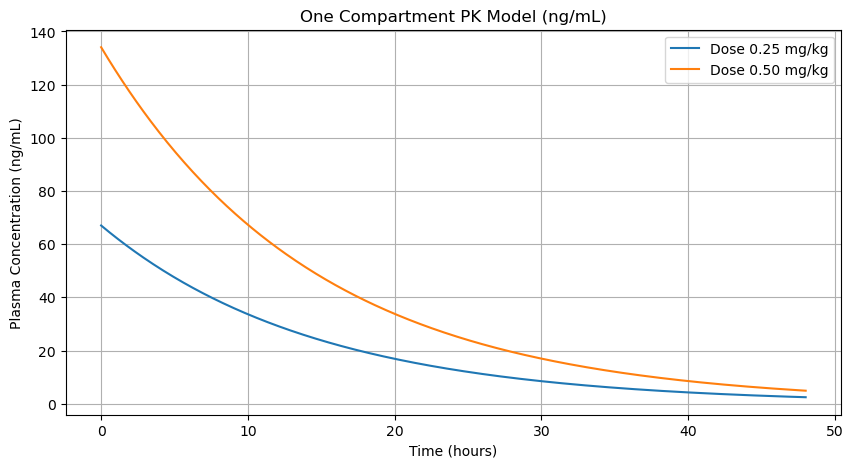

Initial concentration for 0.25 mg/kg dose: 67.02412868632707 ng/mL
Initial concentration for 0.50 mg/kg dose: 134.04825737265415 ng/mL


In [1]:
#Set up PK to transfer drug output to Recp-Comp Model 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# Define ODE for the one-compartment model
def one_compartment_model(A, t, CL, V):
    dA_dt = -CL / V * A
    return dA_dt

# Parameters for the PK model
BW = 70  # Body Weight in kg
CL_per_kg = 0.257  # Clearance in L/h/kg
V_per_kg = 3.73  # Volume in L/kg

# Calculate total body clearance and volume
CL = CL_per_kg * BW * 1000  # Clearance in mL/h
V = V_per_kg * BW * 1000  # Volume in mL

# Define doses in mg/kg
dose_025mgkg = 0.25
dose_050mgkg = 0.5

# Convert doses to total mg for a 70 kg human
dose_25mg = dose_025mgkg * BW
dose_50mg = dose_050mgkg * BW

# Convert doses to ng (1 mg = 1e6 ng)
mg2ng = 1e6
dose_25e6ng = dose_25mg * mg2ng
dose_50e6ng = dose_50mg * mg2ng

# Time points where the solution is computed
t_pk = np.linspace(0, 48, 500)  # 0 to 48 hours

# Solve the differential equation for each dose in ng
A_025_ng = odeint(one_compartment_model, dose_25e6ng, t_pk, args=(CL, V))
A_050_ng = odeint(one_compartment_model, dose_50e6ng, t_pk, args=(CL, V))

# Calculate concentration in ng/mL
C_025_ng = A_025_ng / V
C_050_ng = A_050_ng / V

# Convert to data frame for plotting
df_025_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_025_ng.flatten(), 'Dose': '0.25 mg/kg'})
df_050_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_050_ng.flatten(), 'Dose': '0.50 mg/kg'})

# Combine data frames
combined_data_ng = pd.concat([df_025_ng, df_050_ng])

# Plotting the results for ng/mL
plt.figure(figsize=(10, 5))
for dose, group in combined_data_ng.groupby('Dose'):
    plt.plot(group['Time'], group['Concentration'], label=f'Dose {dose}')

plt.xlabel('Time (hours)')
plt.ylabel('Plasma Concentration (ng/mL)')
plt.title('One Compartment PK Model (ng/mL)')
plt.legend()
plt.grid()
plt.show()

# Verifying initial concentrations
print(f"Initial concentration for 0.25 mg/kg dose: {dose_25e6ng / V} ng/mL")
print(f"Initial concentration for 0.50 mg/kg dose: {dose_50e6ng / V} ng/mL")


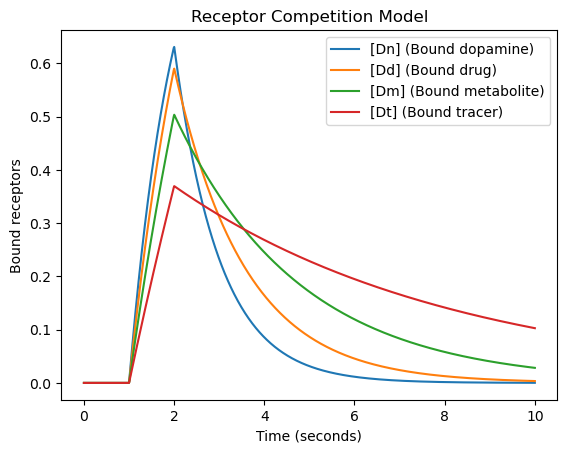

In [2]:
## Simple stand alone Recept-Comp model. Not yet using PK input. 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define time-varying concentrations for competition
def concentrations(t):
    if 1 <= t <= 2:
        dop = 1.0
        drug = 1.0
        met = 1.0
        tracer = 1.0
    else:
        dop = 0.0
        drug = 0.0
        met = 0.0
        tracer = 0.0
    return dop, drug, met, tracer

# Define differential equations with unique on and off rates for dop, drug, metab, tracer
def receptor_competition(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df):
    Dn, Dd, Dm, Dt = y
    dop, drug, met, tracer = concentrations(t)
    dDn_dt = K_on_dop * dop * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * met * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * tracer * Df - K_on_tracer * K_d_tracer * Dt
    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt]

# Parameters (example values, update to match PET imaging lit.)
K_on_dop = 1.0  # Rate constant for binding dopamine, placeholder update
K_d_dop = 1.0   # Dissociation constant for dopamine, placeholder update
K_on_drug = 0.8  # Rate constant for binding drug, placeholder update
K_d_drug = 0.8   # Dissociation constant for drug, placeholder update
K_on_met = 0.6  # Rate constant for binding metabolite, placeholder update
K_d_met = 0.6   # Dissociation constant for metabolite, placeholder update
K_on_tracer = 0.4  # Rate constant for binding tracer, placeholder update
K_d_tracer = 0.4   # Dissociation constant for tracer, placeholder update
Df = 1.0    # Free receptor concentration, placeholder update

# Initial conditions for [Dn], [Dd], [Dm], [Dt]
initial_conditions = [0.0, 0.0, 0.0, 0.0]

# Time points for solving ODE
t = np.linspace(0, 10, 1000)  # 10 seconds, 1000 points

# Solve the system of ODEs
solution = odeint(receptor_competition, initial_conditions, t, args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df))

# Extract the solutions
Dn = solution[:, 0]
Dd = solution[:, 1]
Dm = solution[:, 2]
Dt = solution[:, 3]

# Plot the results
plt.plot(t, Dn, label='[Dn] (Bound dopamine)')
plt.plot(t, Dd, label='[Dd] (Bound drug)')
plt.plot(t, Dm, label='[Dm] (Bound metabolite)')
plt.plot(t, Dt, label='[Dt] (Bound tracer)')
plt.xlabel('Time (seconds)')
plt.ylabel('Bound receptors')
plt.title('Receptor Competition Model')
plt.legend()
plt.show()


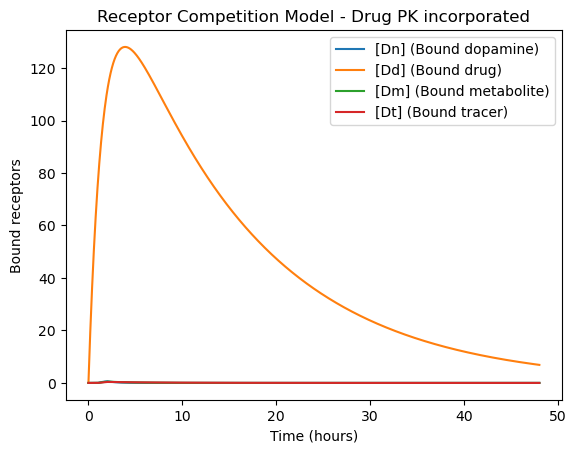

In [3]:
## Incorporate DRUG output of PK to Recpt-Comp. 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define time-varying concentrations for competition using the PK model output
def concentrations(t, pk_concentrations, time_points):
    drug_concentration = np.interp(t, time_points, pk_concentrations)
    dop = 1.0 if 1 <= t <= 2 else 0.0
    met = 1.0 if 1 <= t <= 2 else 0.0
    tracer = 1.0 if 1 <= t <= 2 else 0.0
    return dop, drug_concentration, met, tracer

# Define differential equations with unique on and off rates for dop, drug, metab, tracer
def receptor_competition(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df, pk_concentrations, time_points):
    Dn, Dd, Dm, Dt = y
    dop, drug, met, tracer = concentrations(t, pk_concentrations, time_points)
    dDn_dt = K_on_dop * dop * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * met * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * tracer * Df - K_on_tracer * K_d_tracer * Dt
    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt]

# Parameters for the receptor competition model (example values, update to match PET imaging lit.)
K_on_dop = 1.0  # Rate constant for binding dopamine, placeholder update
K_d_dop = 1.0   # Dissociation constant for dopamine, placeholder update
K_on_drug = 0.8  # Rate constant for binding drug, placeholder update
K_d_drug = 0.8   # Dissociation constant for drug, placeholder update
K_on_met = 0.6  # Rate constant for binding metabolite, placeholder update
K_d_met = 0.6   # Dissociation constant for metabolite, placeholder update
K_on_tracer = 0.4  # Rate constant for binding tracer, placeholder update
K_d_tracer = 0.4   # Dissociation constant for tracer, placeholder update
Df = 1.0    # Free receptor concentration, placeholder update

# Initial conditions for [Dn], [Dd], [Dm], [Dt]
initial_conditions = [0.0, 0.0, 0.0, 0.0]

# Time points for solving ODE
t_rc = np.linspace(0, 48, 1000)  # 48 hours, 1000 points

# Select the dose for receptor competition model (e.g., 0.50 mg/kg)
pk_concentrations = C_050_ng.flatten()
time_points = t_pk

# Solve the system of ODEs
solution = odeint(receptor_competition, initial_conditions, t_rc, args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df, pk_concentrations, time_points))

# Extract the solutions
Dn = solution[:, 0]
Dd = solution[:, 1]
Dm = solution[:, 2]
Dt = solution[:, 3]

# Plot the results
plt.plot(t_rc, Dn, label='[Dn] (Bound dopamine)')
plt.plot(t_rc, Dd, label='[Dd] (Bound drug)')
plt.plot(t_rc, Dm, label='[Dm] (Bound metabolite)')
plt.plot(t_rc, Dt, label='[Dt] (Bound tracer)')
plt.xlabel('Time (hours)')
plt.ylabel('Bound receptors')
plt.title('Receptor Competition Model - Drug PK incorporated')
plt.legend()
plt.show()


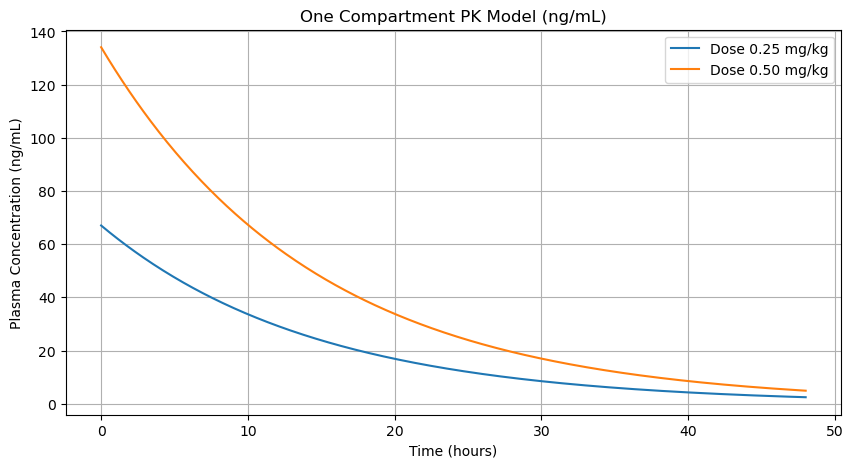

Initial concentration for 0.25 mg/kg dose: 67.02412868632707 ng/mL
Initial concentration for 0.50 mg/kg dose: 134.04825737265415 ng/mL


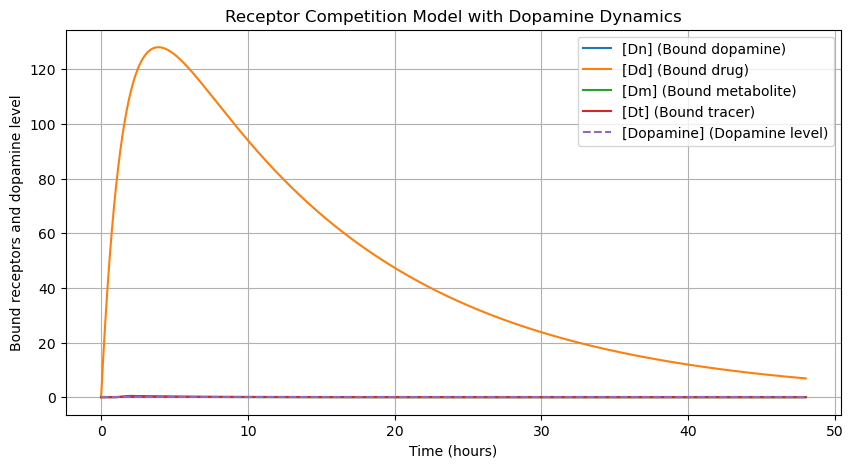

In [4]:
## Incorporate dopamine release dynamics

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# Define ODE for the one-compartment model
def one_compartment_model(A, t, CL, V):
    dA_dt = -CL / V * A
    return dA_dt

# Parameters for the PK model
BW = 70  # Body Weight in kg
CL_per_kg = 0.257  # Clearance in L/h/kg
V_per_kg = 3.73  # Volume in L/kg

# Calculate total body clearance and volume
CL = CL_per_kg * BW * 1000  # Clearance in mL/h
V = V_per_kg * BW * 1000  # Volume in mL

# Define doses in mg/kg
dose_025mgkg = 0.25
dose_050mgkg = 0.5

# Convert doses to total mg for a 70 kg human
dose_25mg = dose_025mgkg * BW
dose_50mg = dose_050mgkg * BW

# Convert doses to ng (1 mg = 1e6 ng)
mg2ng = 1e6
dose_25e6ng = dose_25mg * mg2ng
dose_50e6ng = dose_50mg * mg2ng

# Time points where the solution is computed
t_pk = np.linspace(0, 48, 500)  # 0 to 48 hours

# Solve the differential equation for each dose in ng
A_025_ng = odeint(one_compartment_model, dose_25e6ng, t_pk, args=(CL, V))
A_050_ng = odeint(one_compartment_model, dose_50e6ng, t_pk, args=(CL, V))

# Calculate concentration in ng/mL
C_025_ng = A_025_ng / V
C_050_ng = A_050_ng / V

# Convert to data frame for plotting
df_025_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_025_ng.flatten(), 'Dose': '0.25 mg/kg'})
df_050_ng = pd.DataFrame({'Time': t_pk, 'Concentration': C_050_ng.flatten(), 'Dose': '0.50 mg/kg'})

# Combine data frames
combined_data_ng = pd.concat([df_025_ng, df_050_ng])

# Plotting the results for ng/mL
plt.figure(figsize=(10, 5))
for dose, group in combined_data_ng.groupby('Dose'):
    plt.plot(group['Time'], group['Concentration'], label=f'Dose {dose}')

plt.xlabel('Time (hours)')
plt.ylabel('Plasma Concentration (ng/mL)')
plt.title('One Compartment PK Model (ng/mL)')
plt.legend()
plt.grid()
plt.show()

# Verifying initial concentrations
print(f"Initial concentration for 0.25 mg/kg dose: {dose_25e6ng / V} ng/mL")
print(f"Initial concentration for 0.50 mg/kg dose: {dose_50e6ng / V} ng/mL")

# Dopamine release dynamics
half_life = 0.1  # Half-life of dopamine decay in hours
release0 = 1.0  # Base release amount
relScale = 0.5  # Maximum relative change for release
relSens = 1.0   # Sensitivity to presynaptic receptor
normBound = 1.0 # Normal presynaptic binding

def dopamine_decay(t, last_release_time):
    return np.exp(-np.log(2) * (t - last_release_time) / half_life)

def calculate_new_release(rec_act, release0, relScale, relSens, normBound):
    return release0 * (1 + relScale * (1 - 2 * (relSens / (relSens + normBound))))

# Define time-varying concentrations for competition using the PK model output
def concentrations(t, pk_concentrations, time_points, dopamine_level):
    drug_concentration = np.interp(t, time_points, pk_concentrations)
    met = 1.0 if 1 <= t <= 2 else 0.0
    tracer = 1.0 if 1 <= t <= 2 else 0.0
    return dopamine_level, drug_concentration, met, tracer

# Define differential equations with unique on and off rates for dop, drug, metab, tracer
def receptor_competition(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df, pk_concentrations, time_points, dopamine_levels, last_release_times):
    Dn, Dd, Dm, Dt, dopamine_level = y
    dop, drug, met, tracer = concentrations(t, pk_concentrations, time_points, dopamine_level)

    # Update dopamine level with decay
    dopamine_level *= dopamine_decay(t, last_release_times[-1])

    # Update dopamine level with new release at specific times (example every 1 hour)
    if t in np.arange(1, 48, 1):
        last_release_time = t - 0.15  # 150 ms before current release event in hours
        rec_act = Dn  # Example receptor activation at last release time
        dopamine_level += calculate_new_release(rec_act, release0, relScale, relSens, normBound)
        last_release_times.append(t)

    dDn_dt = K_on_dop * dop * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * met * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * tracer * Df - K_on_tracer * K_d_tracer * Dt

    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt, dopamine_level]

# Parameters for the receptor competition model (example values, update to match PET imaging lit.)
K_on_dop = 1.0  # Rate constant for binding dopamine, placeholder update
K_d_dop = 1.0   # Dissociation constant for dopamine, placeholder update
K_on_drug = 0.8  # Rate constant for binding drug, placeholder update
K_d_drug = 0.8   # Dissociation constant for drug, placeholder update
K_on_met = 0.6  # Rate constant for binding metabolite, placeholder update
K_d_met = 0.6   # Dissociation constant for metabolite, placeholder update
K_on_tracer = 0.4  # Rate constant for binding tracer, placeholder update
K_d_tracer = 0.4   # Dissociation constant for tracer, placeholder update
Df = 1.0    # Free receptor concentration, placeholder update

# Initial conditions for [Dn], [Dd], [Dm], [Dt], and dopamine level
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]
last_release_times = [0]  # Initial release time

# Time points for solving ODE
t_rc = np.linspace(0, 48, 1000)  # 48 hours, 1000 points

# Select the dose for receptor competition model (e.g., 0.50 mg/kg)
pk_concentrations = C_050_ng.flatten()
time_points = t_pk

# Solve the system of ODEs
solution = odeint(receptor_competition, initial_conditions, t_rc, args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met, K_on_tracer, K_d_tracer, Df, pk_concentrations, time_points, 0.0, last_release_times))

# Extract the solutions
Dn = solution[:, 0]
Dd = solution[:, 1]
Dm = solution[:, 2]
Dt = solution[:, 3]
dopamine_levels = solution[:, 4]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dn, label='[Dn] (Bound dopamine)')
plt.plot(t_rc, Dd, label='[Dd] (Bound drug)')
plt.plot(t_rc, Dm, label='[Dm] (Bound metabolite)')
plt.plot(t_rc, Dt, label='[Dt] (Bound tracer)')
plt.plot(t_rc, dopamine_levels, label='[Dopamine] (Dopamine level)', linestyle='--')
plt.xlabel('Time (hours)')
plt.ylabel('Bound receptors and dopamine level')
plt.title('Receptor Competition Model with Dopamine Dynamics')
plt.legend()
plt.grid()
plt.show()
